In [1]:
import os
import glob

import numpy as np
from matplotlib import pyplot as plt

In [2]:
# These lines of code are setting various parameters for the appearance of plots created using the matplotlib library. 
plt.rc('font', family='serif')
plt.rc('text', usetex=False)
plt.rc('font', family='serif', size=20)
plt.rcParams['axes.linewidth'] = 1.5
plt.rcParams['xtick.major.size'] = 10
plt.rcParams['xtick.minor.size'] = 5
plt.rcParams['ytick.major.size'] = 10
plt.rcParams['ytick.minor.size'] = 5
plt.rcParams['xtick.minor.visible'] = True
plt.rcParams['ytick.minor.visible'] = True
plt.rcParams['xtick.top'] = True
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
plt.rcParams['ytick.right'] = True
plt.rcParams['figure.figsize'] = (30.0, 8.0)   #13,8   # Determina o tamanho do plot dentro do ipython notebook
plt.rcParams['xtick.major.width']  = 1
plt.rcParams['ytick.major.width']  = 1
plt.rcParams['xtick.major.pad']= 8

In [3]:
tracer = 'QSO'
region = 'NGC' # choices=['NGC', 'SGC', 'NS', 'S', 'NGCS', 'SGCS', 'N']
theory_name = 'fs'
clustering_statistics = 'pk' # choices=['pk', 'xi']
zmin, zmax, b0 = {'LRG': (0.4, 1.1, 1.7), 'ELG': (1.1, 1.6, 0.84), 'QSO': (1.6, 2.1, 1.2)}[tracer]

In [4]:
base_dir = '/global/cfs/cdirs/desi/users/uendert/blinding/' #'/global/homes/u/uendert/desi-y1-kp45/blinding' #'..'
profiles_fn = sorted(glob.glob(os.path.join(base_dir, 'blinded', 'test_w0-*','on_the_fly_GaussianCovariance_matrix', '{}'.format(theory_name), '{}'.format(clustering_statistics), 'profile_{}_{}_{}_{}.npy'.format(tracer, region, zmin, zmax))))
profiles_unblinded_fn = os.path.join(base_dir, 'unblinded','on_the_fly_GaussianCovariance_matrix', '{}'.format(theory_name), '{}'.format(clustering_statistics),'profile_{}_{}_{}_{}.npy'.format(tracer, region, zmin, zmax))

In [5]:
from desilike.samples import Profiles

In [6]:
bestfit = {name: [] for name in ['qpar', 'qper', 'dm', 'df', 'chi2min']}
error = {name: [] for name in ['qpar', 'qper', 'dm', 'df']}
expected = {name: [] for name in ['qpar', 'qper', 'dm', 'df']}
expected_unblinded = {}

from desilike.samples import Profiles
profiles_unblinded = Profiles.load(profiles_unblinded_fn)
index = profiles_unblinded.bestfit.logposterior.argmax()

bestfit_unblinded = {name: profiles_unblinded.bestfit[name][index] for name in error}
bestfit_unblinded['qiso'] = bestfit_unblinded['qpar']**(1./3.) * bestfit_unblinded['qper']**(2./3.)
bestfit_unblinded['chi2min'] = profiles_unblinded.bestfit.chi2min
# bestfit_unblinded['chi2min_red'] = float(profiles.bestfit.chi2min / profiles.bestfit.attrs['ndof'])
error_unblinded = {name: profiles_unblinded.error[name][index] for name in error}
for name in error_unblinded: error_unblinded[name] = error_unblinded[name]
                   
expected_unblinded['qpar'] = profiles_unblinded.attrs['expected']['qpar']
expected_unblinded['qper'] = profiles_unblinded.attrs['expected']['qper']
expected_unblinded['dm'] = profiles_unblinded.attrs['expected']['dm']
expected_unblinded['df'] = profiles_unblinded.attrs['expected']['df']

cov_unblinded = profiles_unblinded.covariance.view(params=['qper', 'qpar'])
jac = np.array([2.0 / 3.0, 1.0 / 3.0])
qiso_error_unblinded = {'qiso': jac.dot(cov_unblinded).dot(jac)**0.5}

qiso_error, qiso_error_fixed_covmat_unblinded = [], []

for profiles_fn_ in profiles_fn:
    profiles = Profiles.load(profiles_fn_)
    for name in expected: expected[name].append(profiles.attrs['expected'][name])
    index = profiles.bestfit.logposterior.argmax()
    for name in error: bestfit[name].append(profiles.bestfit[name][index])
    for name in error: error[name].append(profiles.error[name][index])
    cov = profiles.covariance.view(params=['qper', 'qpar'])
    jac = np.array([2.0 / 3.0, 1.0 / 3.0])
    qiso_error.append(jac.dot(cov).dot(jac)**0.5)    
    bestfit['chi2min'].append(float(profiles.bestfit.chi2min))

bestfit['qiso'] = list(np.array(bestfit['qpar'])**(1./3.) * np.array(bestfit['qper'])**(2./3.))
expected['qiso'] = list(np.array(expected['qpar'])**(1./3.) * np.array(expected['qper'])**(2./3.))
expected['dm'] = [0.] * len(expected['dm'])
error['qiso'] = qiso_error

error_unblinded['qiso'] = qiso_error_unblinded['qiso']

In [7]:
import pandas as pd

In [8]:
df_error_unblinded = pd.DataFrame(error_unblinded, index=[0])
df_error_unblinded.rename(columns={"qpar": "qpar_err", "qper": "qper_err", "dm": "dm_err", "df": "df_err", "qiso": "qiso_err"}, inplace=True)
df_error = pd.DataFrame(error)
df_error.rename(columns={"qpar": "qpar_err", "qper": "qper_err", "dm": "dm_err", "df": "df_err", "qiso": "qiso_err"}, inplace=True)

In [9]:
df_error_unblinded

,qpar_err,qper_err,dm_err,df_err,qiso_err
0,0.046843,0.022477,0.056852,0.094979,0.020652


In [10]:
df_error

,qpar_err,qper_err,dm_err,df_err,qiso_err
0,0.050587,0.019241,0.058371,0.082736,0.020704
1,0.057369,0.022054,0.067660,0.088402,0.022478
2,0.054240,0.020593,0.064392,0.097858,0.020615
3,0.046429,0.019974,0.059996,0.100162,0.019138
4,0.044831,0.022136,0.060231,0.097283,0.019782
5,0.050862,0.019627,0.053916,0.094205,0.020380
6,0.049296,0.022197,0.060793,0.097734,0.019604
7,0.049380,0.020503,0.063314,0.088745,0.019025


In [11]:
unblinded_cosmo = {'w0': -1.0, 'wa': 0.0, 'f': 0.8}
unblinded_cosmo.update(bestfit_unblinded)
unblinded_cosmo.update({'ndof': profiles_unblinded.bestfit.attrs['ndof']})
cosmo_unblinded = pd.DataFrame(unblinded_cosmo, index=[0])
cosmo_unblinded = pd.concat([cosmo_unblinded, df_error_unblinded], axis=1)
cosmo_unblinded

,w0,wa,f,qpar,qper,dm,df,qiso,chi2min,ndof,qpar_err,qper_err,dm_err,df_err,qiso_err
0,-1.0,0.0,0.8,1.017872,0.950043,0.012315,0.844891,0.972135,40.002932,95,0.046843,0.022477,0.056852,0.094979,0.020652


In [12]:
base = '/global/cfs/cdirs/desi/survey/catalogs/main/mocks/FirstGenMocks/AbacusSummit/Y1/mock1/LSScats/'
data_dir = base + 'blinded/jmena/test_w0-*/LSScats/blinded/'
fn_list = sorted(glob.glob(os.path.join(data_dir, 'blinded_parameters_{}.csv'.format(tracer))))

cosmo_blinded = {name: [] for name in ['w0', 'wa', 'f']}
ndof = {name: [] for name in ['ndof']}
for j, profiles_fn_ in zip(fn_list, profiles_fn):
    w0_blind, wa_blind, f_blind = np.loadtxt(j, delimiter=',', skiprows=1)
    cosmo_blinded['w0'].append(w0_blind)
    cosmo_blinded['wa'].append(wa_blind)
    cosmo_blinded['f'].append(f_blind)
    ndof['ndof'].append(profiles.bestfit.attrs['ndof'])

cosmo_blinded.update(bestfit)
cosmo_blinded.update(df_error)
cosmo_blinded.update(ndof)
cosmo_blinded = pd.DataFrame(cosmo_blinded)

blinded_concat = pd.concat([cosmo_unblinded, cosmo_blinded ], axis=0)

In [13]:
cosmo_unblinded

,w0,wa,f,qpar,qper,dm,df,qiso,chi2min,ndof,qpar_err,qper_err,dm_err,df_err,qiso_err
0,-1.0,0.0,0.8,1.017872,0.950043,0.012315,0.844891,0.972135,40.002932,95,0.046843,0.022477,0.056852,0.094979,0.020652


In [14]:
blinded_concat

,w0,wa,f,qpar,qper,dm,df,qiso,chi2min,ndof,qpar_err,qper_err,dm_err,df_err,qiso_err
0,-1.000000,0.000000,0.800000,1.017872,0.950043,0.012315,0.844891,0.972135,40.002932,95,0.046843,0.022477,0.056852,0.094979,0.020652
0,-0.904004,0.025634,0.880000,1.016265,0.954576,0.035200,1.091297,0.974711,44.478117,95,0.050587,0.019241,0.058371,0.082736,0.020704
1,-0.905703,-0.683114,0.720000,1.045234,0.926897,-0.025057,0.585008,0.964774,37.564935,95,0.057369,0.022054,0.067660,0.088402,0.022478
2,-0.970440,-0.507778,0.720000,1.021821,0.935353,-0.044535,0.695533,0.963331,51.852581,95,0.054240,0.020593,0.064392,0.097858,0.020615
3,-0.996230,0.289309,0.880000,0.997691,0.957622,0.045738,1.076211,0.970797,47.234345,95,0.046429,0.019974,0.059996,0.100162,0.019138
4,-1.048543,0.140157,0.776001,0.997103,0.941662,0.022728,0.810798,0.959791,42.223382,95,0.044831,0.022136,0.060231,0.097283,0.019782
5,-1.106392,0.454786,0.822949,1.024159,0.938254,0.035116,0.880782,0.966057,42.482261,95,0.050862,0.019627,0.053916,0.094205,0.020380
6,-1.161697,0.374612,0.720000,1.046145,0.939649,-0.042803,0.666646,0.973885,42.946460,95,0.049296,0.022197,0.060793,0.097734,0.019604
7,-1.233470,0.765853,0.732663,1.050933,0.930588,0.011393,0.605821,0.969088,40.044140,95,0.049380,0.020503,0.063314,0.088745,0.019025


In [15]:
df = pd.DataFrame(blinded_concat)
df = df[["w0", "wa", "f", "qpar", "qpar_err", "qper", "qper_err", "qiso", "qiso_err", "dm", "dm_err", "df", "df_err", "chi2min", "ndof"]]

print(df.to_latex(index=False,
                  formatters={"name": str.upper},
                  float_format="{:0.4f}".format, multirow = False))

\begin{tabular}{rrrrrrrrrrrrrrr}
\toprule
     w0 &      wa &      f &   qpar &  qpar\_err &   qper &  qper\_err &   qiso &  qiso\_err &      dm &  dm\_err &     df &  df\_err &  chi2min &  ndof \\
\midrule
-1.0000 &  0.0000 & 0.8000 & 1.0179 &    0.0468 & 0.9500 &    0.0225 & 0.9721 &    0.0207 &  0.0123 &  0.0569 & 0.8449 &  0.0950 &  40.0029 &    95 \\
-0.9040 &  0.0256 & 0.8800 & 1.0163 &    0.0506 & 0.9546 &    0.0192 & 0.9747 &    0.0207 &  0.0352 &  0.0584 & 1.0913 &  0.0827 &  44.4781 &    95 \\
-0.9057 & -0.6831 & 0.7200 & 1.0452 &    0.0574 & 0.9269 &    0.0221 & 0.9648 &    0.0225 & -0.0251 &  0.0677 & 0.5850 &  0.0884 &  37.5649 &    95 \\
-0.9704 & -0.5078 & 0.7200 & 1.0218 &    0.0542 & 0.9354 &    0.0206 & 0.9633 &    0.0206 & -0.0445 &  0.0644 & 0.6955 &  0.0979 &  51.8526 &    95 \\
-0.9962 &  0.2893 & 0.8800 & 0.9977 &    0.0464 & 0.9576 &    0.0200 & 0.9708 &    0.0191 &  0.0457 &  0.0600 & 1.0762 &  0.1002 &  47.2343 &    95 \\
-1.0485 &  0.1402 & 0.7760 & 0.9971 & 

/tmp/ipykernel_21362/4214409729.py:4: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(df.to_latex(index=False,


In [16]:
print(r'qiso_unblinded = {:.5} \pm {:.5}'.format(bestfit_unblinded['qiso'], qiso_error_unblinded['qiso'] ))

qiso_unblinded = 0.97213 \pm 0.020652


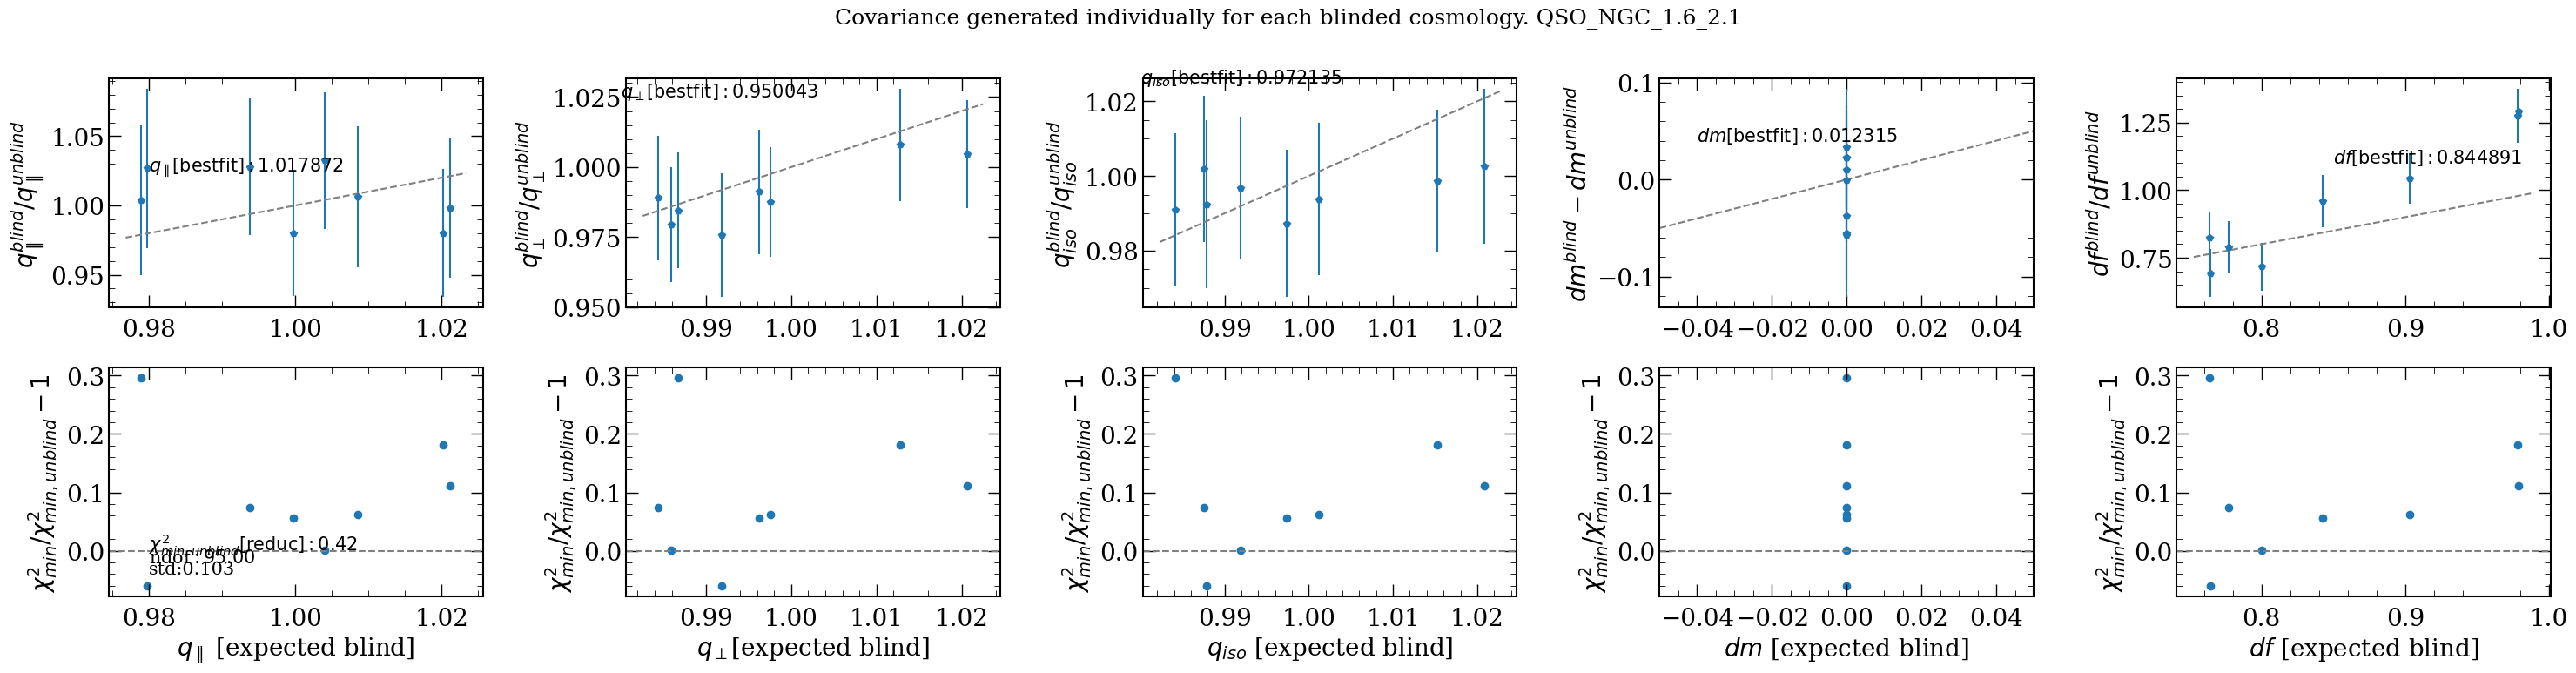

In [17]:
fig, ax = plt.subplots(2, 5, sharex='col')

ax[0, 0].errorbar(expected['qpar'], bestfit['qpar'] / bestfit_unblinded['qpar'], yerr=error['qpar'], fmt='p') #row=0, col=0
ax[0, 0].tick_params('x', labelbottom=True)
ax[0, 0].set(ylabel=r'$q_{\parallel}^{blind} / q_{\parallel}^{unblind}$')
ax[0, 0].plot(ax[0, 0].get_xlim(), ax[0, 0].get_xlim(), c='gray', linestyle='--')
ax[0, 0].text(0.98, 1.025, r'$q_{\parallel}{\rm[bestfit]}: %f$' % (bestfit_unblinded['qpar']), fontsize=15)

ax[1, 0].scatter(expected['qpar'], bestfit['chi2min'] / bestfit_unblinded['chi2min'] - 1.) #row=1, col=0
ax[1, 0].set(ylabel=r'$\chi^2_{min} / \chi^2_{min, unblind} - 1$', xlabel=r'$q_{\parallel}$ [expected blind]')
ax[1, 0].axhline(y=0., color='gray', linestyle='--')
chi2min_red = profiles_unblinded.bestfit.chi2min / profiles_unblinded.bestfit.attrs['ndof']
if clustering_statistics == 'pk':
    ax[1, 0].text(0.98, 0., r'$\chi^2_{min, unblind}{\rm[reduc]}: %.2f$' % (chi2min_red), fontsize=15)
    chi2min_std = np.array(bestfit['chi2min'] / bestfit_unblinded['chi2min'] - 1.).std()
    ax[1, 0].text(0.98, -0.04, r'std:{:.3}'.format(chi2min_std), fontsize=15)
    ax[1, 0].text(0.98, -0.02, r'ndof$: %.2f$' % (profiles_unblinded.bestfit.attrs['ndof']), fontsize=15)
else:
    ax[1, 0].text(0.98, 0.2, r'$\chi^2_{min, unblind}{\rm[reduc]}: %.2f$' % (chi2min_red), fontsize=15)
    chi2min_std = np.array(bestfit['chi2min'] / bestfit_unblinded['chi2min'] - 1.).std()
    ax[1, 0].text(0.98, 0.1, r'std:{:.3}'.format(chi2min_std), fontsize=15)
    ax[1, 0].text(0.98, 0.15, r'ndof$: %.2f$' % (profiles_unblinded.bestfit.attrs['ndof']), fontsize=15)


ax[0, 1].errorbar(expected['qper'], bestfit['qper'] / bestfit_unblinded['qper'], yerr=error['qper'], fmt='p') #row=0, col=1
ax[0, 1].tick_params('x', labelbottom=True)
ax[0, 1].set( ylabel=r'$q_{\perp}^{blind} / q_{\perp}^{unblind}$')
ax[0, 1].plot(ax[0, 1].get_xlim(), ax[0, 1].get_xlim(), c='gray', linestyle='--')
ax[0, 1].text(0.98, 1.025, r'$q_{\perp}{\rm[bestfit]}: %f$' % (bestfit_unblinded['qper']), fontsize=15)

ax[1, 1].scatter(expected['qper'], bestfit['chi2min'] / bestfit_unblinded['chi2min'] - 1.) #row=1, col=1
ax[1, 1].set(ylabel=r'$\chi^2_{min} / \chi^2_{min, unblind} - 1$', xlabel=r'$q_{\perp}$[expected blind]')
ax[1, 1].axhline(y=0., color='gray', linestyle='--')

ax[0, 2].errorbar(expected['qiso'], bestfit['qiso'] / bestfit_unblinded['qiso'], yerr=error['qiso'], fmt='p') #row=0, col=0
ax[0, 2].tick_params('x', labelbottom=True)
ax[0, 2].set(ylabel=r'$q_{iso}^{blind} / q_{iso}^{unblind}$')
ax[0, 2].plot(ax[0, 2].get_xlim(), ax[0, 2].get_xlim(), c='gray', linestyle='--')
ax[0, 2].text(0.98, 1.025, r'$q_{iso}{\rm[bestfit]}: %f$' % (bestfit_unblinded['qiso']), fontsize=15)

ax[1, 2].scatter(expected['qiso'], bestfit['chi2min'] / bestfit_unblinded['chi2min'] - 1.) #row=1, col=0
ax[1, 2].set(ylabel=r'$\chi^2_{min} / \chi^2_{min, unblind} - 1$', xlabel=r'$q_{iso}$ [expected blind]')
ax[1, 2].axhline(y=0., color='gray', linestyle='--')

ax[0, 3].errorbar(expected['dm'], bestfit['dm'] - bestfit_unblinded['dm'], yerr=error['dm'], fmt='p') #row=0, col=0
ax[0, 3].tick_params('x', labelbottom=True)
ax[0, 3].set(ylabel=r'$dm^{blind} - dm^{unblind}$')
ax[0, 3].set_xlim(-0.05, 0.05)
ax[0, 3].plot(ax[0, 3].get_xlim(), ax[0, 3].get_xlim(), c='gray', linestyle='--')
ax[0, 3].text(-0.04, 0.04, r'$dm{\rm[bestfit]}: %f$' % (bestfit_unblinded['dm']), fontsize=15)

ax[1, 3].scatter(expected['dm'], bestfit['chi2min'] / bestfit_unblinded['chi2min'] - 1.) #row=1, col=0
ax[1, 3].set(ylabel=r'$\chi^2_{min} / \chi^2_{min, unblind} - 1$', xlabel=r'$dm$ [expected blind]')
ax[1, 3].axhline(y=0., color='gray', linestyle='--')

ax[0, 4].errorbar(expected['df'], bestfit['df'] / bestfit_unblinded['df'], yerr=error['df'], fmt='p') #row=0, col=0
ax[0, 4].tick_params('x', labelbottom=True)
ax[0, 4].set(ylabel=r'$df^{blind} / df^{unblind}$')
ax[0, 4].plot(ax[0, 4].get_xlim(), ax[0, 4].get_xlim(), c='gray', linestyle='--')
ax[0, 4].text(0.85, 1.1, r'$df{\rm[bestfit]}: %f$' % (bestfit_unblinded['df']), fontsize=15)

ax[1, 4].scatter(expected['df'], bestfit['chi2min'] / bestfit_unblinded['chi2min'] - 1.) #row=1, col=0
ax[1, 4].set(ylabel=r'$\chi^2_{min} / \chi^2_{min, unblind} - 1$', xlabel=r'$df$ [expected blind]')
ax[1, 4].axhline(y=0., color='gray', linestyle='--')

if clustering_statistics == 'pk':
    fig.suptitle('Covariance generated individually for each blinded cosmology. {}_{}_{}_{}'.format(tracer, region, zmin, zmax), fontsize=18)
else:
    fig.suptitle('Same covariance generated with unblinded cosmology. {}_{}_{}_{}'.format(tracer, region, zmin, zmax), fontsize=18)
plt.tight_layout()
# plt.savefig(os.path.join(base_dir, 'blinded', '{}_one2one_plot_{}_{}_{}_{}.png'.format(clustering_statistics, tracer, region, zmin, zmax)))
plt.show()